# 📊 Options Pricing Experiments

## 🧭 Overview

This notebook explores the domain of **options pricing** by applying a variety of well-established models, including:

- **Binomial Tree**
- **Black-Scholes-Merton**
- **Stochastic Volatility Models**
- **Machine Learning Approaches**

Our goal is to simulate and analyze options behavior using both theoretical and data-driven methodologies.

---

## 📂 Notebook Structure

The notebook is organized into four main sections:

### 1. 🔄 Loading Data
We begin by importing and preparing the necessary financial data. Due to the lack of historical options chain data, we will use proxy instruments.

### 2. 🧪 Synthetic Data Generation
Since full historical options chains are unavailable, we generate synthetic options data using:

- The **SPY** (as the underlying asset)
- The **VIX** (for volatility inputs)
- The **US 4-Week Treasury Yield** (as the risk-free rate)

We then simulate options prices using the aforementioned pricing models.

### 3. 🧮 Sensitivities & Greeks
We analyze **options sensitivities** (commonly referred to as the *Greeks*), and explore various methods for computing:

- Delta, Gamma, Theta, Vega, and Rho
- Finite difference approximations vs. analytical formulas
- Behavior under changing market conditions

### 4. 🧱 Structured Products
We conclude by designing and evaluating **structured products** based on option combinations. This includes:

- Custom payoffs
- Risk/return profiling
- Potential applications in portfolio construction

In [68]:
import sys
sys.path.append("..")
import Data as dt
import ChevalParesseux_lib as lib

import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sets the number of jobs to use for parallel processing
n_jobs = 5

---
## **I. Loading Data**

In [69]:
"""
I. We load the data for the underlying asset (SPY in this case), the VIX index, and the US interest rates.
"""
spy = dt.load_data(ticker='SPY')
spy['code'] = 'SPY'

vix = dt.load_data(ticker='VIX')
vix['code'] = 'VIX'

rates = dt.load_data(ticker='US_rates')
rates['code'] = 'US_rates'

In [70]:
"""
II. Let's make some preprocessing to have the data in the right format.
Particularly, we will keep only the 'date' and 'close' columns for SPY and VIX, and the 'date' and '4 WEEKS COUPON EQUIVALENT' for US rates.
"""
# ----- SPY ------ #
spy_close = spy[['date', 'close']]
spy_close.index = pd.to_datetime(spy_close['date'])
spy_close = spy_close.drop(columns=['date'])

spy_close.rename(columns={'close': 'spy'}, inplace=True)
spy.sort_index(inplace=True)

# ----- VIX ------ #
vix_close = vix[['date', 'close']]
vix_close.index = pd.to_datetime(vix_close['date'])
vix_close = vix_close.drop(columns=['date'])

vix_close.rename(columns={'close': 'vix'}, inplace=True)
vix.sort_index(inplace=True)

# ----- Rates ------ #
rates_4w = rates[['date', '4 WEEKS COUPON EQUIVALENT']]
rates_4w.index = pd.to_datetime(rates_4w['date'])
rates_4w = rates_4w.drop(columns=['date'])

rates_4w.rename(columns={'4 WEEKS COUPON EQUIVALENT': 'us_4w'}, inplace=True)
rates_4w.sort_index(inplace=True)

In [71]:
"""
III. We concatenate the dataframes to have a single dataframe with the 'spy', 'vix', and 'us_4w' columns.
"""
data_df = pd.concat([spy_close, vix_close, rates_4w], axis=1)
data_df = data_df.dropna(axis=0, how='any')

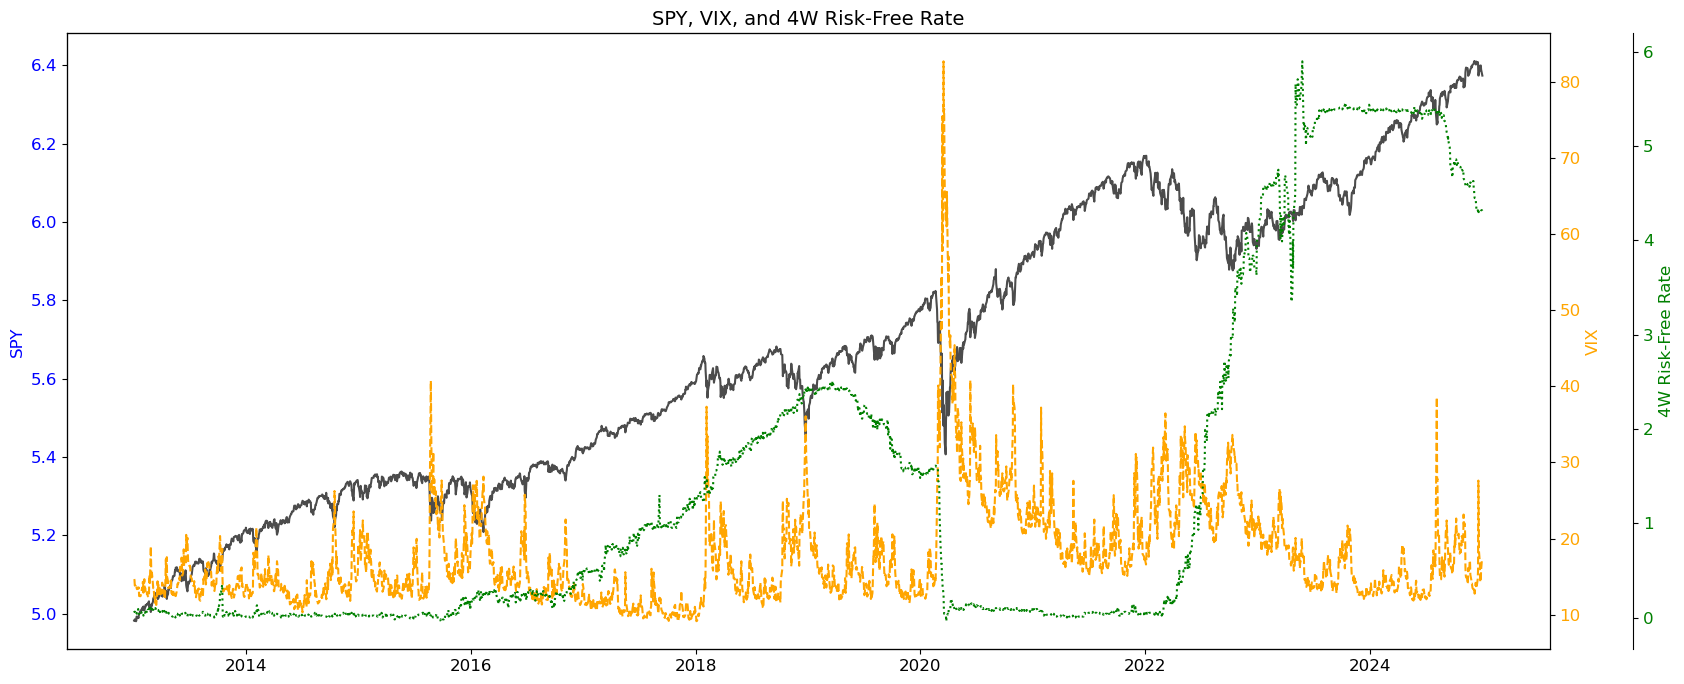

In [72]:
"""
IV. Let's plot the data for better understanding.
"""
fig, ax1 = plt.subplots(figsize=(17, 7))

ax1.plot(data_df.index, np.log(data_df['spy']), color='black', label='SPY Close Price', alpha=0.7)
ax1.set_ylabel('SPY', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(data_df.index, data_df['vix'], color='orange', label='VIX Close Price', linestyle='--')
ax2.set_ylabel('VIX', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(("outward", 60))
ax3.plot(data_df.index, data_df['us_4w'], color='green', label='4W Risk-Free Rate', linestyle=':')
ax3.set_ylabel('4W Risk-Free Rate', color='green')
ax3.tick_params(axis='y', labelcolor='green')

plt.title('SPY, VIX, and 4W Risk-Free Rate')
fig.tight_layout()
plt.show()

---
## **II. Synthetic Data Generation**

With the necessary market data loaded, we now focus on generating **synthetic options chain data**.

The core idea behind this step is to leverage the **VIX** as a proxy for the **implied volatility** observed by options market makers. The VIX is derived under the assumption that participants use a model similar to **Black-Scholes**, where all input parameters (spot price, strike, risk-free rate, and time to maturity) are known—except for volatility.

Hence, the VIX provides a robust estimate of the market's consensus on future volatility. However, it's important to note a few key caveats:

- The VIX is computed by **averaging implied volatilities of near-the-money (ATM) options** with **~30 days to maturity**.
- As a result, it may not accurately reflect the volatility implied by:
  - Deep in/out-of-the-money options
  - Short-dated or long-dated maturities

### 🧰 Approach

We will use:
- **SPY** as the underlying asset
- **VIX** as a proxy for 30-day implied volatility
- **US 4-Week Treasury Yield** as the risk-free rate

With these inputs, we will price synthetic options across a range of strikes and maturities using:
- Black-Scholes
- Binomial Trees
- Other pricing frameworks

This synthetic dataset will serve as a foundation for later analysis of **Greeks** and **structured product construction**.


In [73]:
"""
I. Let's define the characteristics of our options chain.
"""
options_chain_df = pd.DataFrame({
    'underlying': ['SPY'] * 40,
    'strike_pct': [80, 85, 90, 95, 100, 105, 110, 115, 120, 125] * 4, # expressed in % of the underlying price
    'time_to_maturity': [10] * 10 + [20] * 10 + [30] * 10 + [40] * 10, # in days
})

options_chain_df['id'] = options_chain_df.apply(lambda row: f'K{row["strike_pct"]}_T{row["time_to_maturity"]}', axis=1)

In [74]:
"""
II. Gathering the data for each option in the options chain. For this experiment we will use options of the same characteristic each day.
The thing that will be the closer to this in real life would be to buy each day the option with the same strike and time to maturity. Of course, 
this is not realistic as the options chain changes every day, but for the sake of this experiment we will assume that we can buy the same option every day.
"""
options_chain = {}
for idx, row in options_chain_df.iterrows():
    option_df = data_df.copy()
    option_df['strike'] = row['strike_pct'] / 100 * option_df['spy']
    option_df['time_to_maturity'] = row['time_to_maturity']
    option_df['id'] = row['id']

    options_chain[row['id']] = option_df

# Quick check of the options chain
options_chain['K110_T10']

,spy,vix,us_4w,strike,time_to_maturity,id
date,,,,,,
2013-01-02,145.82,14.68,0.07,160.402,10,K110_T10
2013-01-03,145.73,14.56,0.06,160.303,10,K110_T10
2013-01-04,146.33,13.83,0.06,160.963,10,K110_T10
2013-01-07,145.99,13.79,0.05,160.589,10,K110_T10
2013-01-08,145.62,13.62,0.06,160.182,10,K110_T10
...,...,...,...,...,...,...
2024-12-24,601.30,14.27,4.32,661.430,10,K110_T10
2024-12-26,601.34,14.73,4.33,661.474,10,K110_T10
2024-12-27,595.01,15.95,4.32,654.511,10,K110_T10


In [75]:
"""
III. Let's compute the "real" prices of the options by assuming we already know the future price of the underlying asset (SPY) at maturity.
"""
def get_european_real(
    spot: float, 
    strike: float, 
    maturity: float, 
    risk_free_rate: float, 
) -> tuple:
    """
    Computes the "real" price of a European call and put option at maturity.
    
    Parameters:
        spot (float): Current price of the underlying asset.
        strike (float): Strike price of the option.
        maturity (float): Time to maturity in years.
        risk_free_rate (float): Risk-free interest rate as a decimal.
    
    Returns:
        tuple: A tuple containing the call and put option prices at maturity.
    """
    # ======= I. Calculate payoff =======
    call_payoff = max(spot - strike, 0)
    put_payoff = max(strike - spot, 0)
    
    # ======= III. Calculate present value of payoffs =======
    call_price = np.exp(-risk_free_rate * maturity) * call_payoff
    put_price = np.exp(-risk_free_rate * maturity) * put_payoff
    
    return call_price, put_price

for key, df in tqdm(options_chain.items(), desc="Processing option chains"):
    
    # ----- 1. Shift the SPY prices to the future date based on time to maturity -----
    temp_df = df.copy()
    temp_df['spy'] = temp_df['spy'].shift(-temp_df['time_to_maturity'].iloc[0])  # Shift SPY prices to the future date
    
    # ----- 2. Compute the "real" price of the option -----
    call_put_prices = [
        get_european_real(
            spot=row['spy'],  
            strike=row['strike'], 
            maturity=row['time_to_maturity'] / 365,  # Convert days to years
            risk_free_rate=row['us_4w'] / 100,       # Convert % to decimal
        )
        for _, row in temp_df.iterrows()
    ]

    # Unpack the results
    df['call_real'], df['put_real'] = zip(*call_put_prices)

Processing option chains: 100%|██████████| 40/40 [00:03<00:00, 13.33it/s]


# 📈 The Black-Scholes Model

## ⚖️ Assumptions of the Black-Scholes Model

The BSM model relies on a set of simplifying assumptions that allow for an elegant mathematical solution. These assumptions include:

1. **No Arbitrage**: The model assumes that arbitrage opportunities do not exist in the market.
2. **Efficient Markets**: All market participants have equal access to information, and prices reflect all known information.
3. **Constant Risk-Free Rate**: The risk-free rate remains constant over the option's life.
4. **Log-Normal Stock Price Distribution**: The stock prices follow a **Geometric Brownian Motion (GBM)**, implying they exhibit a continuous log-normal distribution.
5. **No Dividends**: The underlying asset does not pay any dividends during the option's life.
6. **Constant Volatility**: The volatility of the stock price is assumed to be constant over time.

While these assumptions simplify the mathematical framework, they also highlight the model's limitations in real-world applications. Nonetheless, it serves as a powerful tool for understanding the dynamics of option pricing.

## 🔍 The Black-Scholes Equation

The Black-Scholes model is built upon the **Black-Scholes partial differential equation (PDE)**, which governs the price of the option as a function of time and the price of the underlying asset:

$$
\frac{\partial V}{\partial t} + r S \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} = r V
$$

Where:
- $V$ is the value of the option.
- $S$ is the price of the underlying asset.
- $r$ is the risk-free interest rate.
- $\sigma$ is the volatility of the asset price.
- $t$ is time.

The solution to this equation under the right boundary conditions leads to the famous **Black-Scholes pricing formulas** for European call and put options.

## 🛡️ The Risk-Neutral World

A critical concept introduced by the BSM model is that of the **risk-neutral world**. In this framework, all investors are indifferent to risk, meaning that they require no extra return for taking on additional risk. The implication is that the expected return on the underlying asset is equal to the risk-free rate when valuing options, rather than the asset's actual expected return. This simplifies the pricing of derivatives by focusing on replication and arbitrage-free pricing.

In [76]:
"""
I. Let's define the function that computes the price of a European option using the Black-Scholes formula.
"""
def get_european_BS(
    spot: float, 
    strike: float, 
    maturity: float, 
    risk_free_rate: float, 
    volatility: float,
) -> tuple:
    """
    Computes the price of a European option using the Black-Scholes formula.

    Parameters: 
        - spot (float): The current price of the underlying asset.
        - strike (float): The strike price of the option.
        
            => the following parameters should be in the same units!
        - maturity (float): Time to maturity.
        - risk_free_rate (float): The risk-free interest rate.
        - volatility (float): The volatility of the underlying asset.

    Returns:
        tuple: (call_price, put_price)
    """
    # ======= I. Check inputs =======
    if spot <= 0 or strike <= 0 or maturity <= 0 or volatility <= 0:
        raise ValueError("All inputs must be strictly positive.")

    # ======= II. Calculate d1 and d2 =======
    d1 = (np.log(spot / strike) + (risk_free_rate + 0.5 * volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))
    d2 = d1 - volatility * np.sqrt(maturity)

    # ======= III. Calculate N(d1), N(d2), N(-d1), N(-d2) =======
    N_d1 = stats.norm.cdf(d1)
    N_d2 = stats.norm.cdf(d2)
    N_minus_d1 = stats.norm.cdf(-d1)
    N_minus_d2 = stats.norm.cdf(-d2)

    # ======= IV. Calculate call and put prices =======
    call_price = spot * N_d1 - strike * np.exp(-risk_free_rate * maturity) * N_d2
    put_price = strike * np.exp(-risk_free_rate * maturity) * N_minus_d2 - spot * N_minus_d1

    return call_price, put_price


In [77]:
"""
II. Let's compute the prices of the options in the options chain using the Black-Scholes formula.

N.B: The VIX is expressed in annualized volatility, the US_4W is expressed in annualized risk-free rate, and the time to maturity is expressed in days.
so we will need to convert the days to years by dividing by 365 or 252 depending on the context.
"""
# Iterate over each options chain
for key, df in tqdm(options_chain.items(), desc="Processing option chains"):
    
    # Compute Black-Scholes prices
    call_put_prices = [
        get_european_BS(
            spot=row['spy'], 
            strike=row['strike'], 
            maturity=row['time_to_maturity'] / 365,  # Convert days to years
            risk_free_rate=row['us_4w'] / 100,       # Convert % to decimal
            volatility=row['vix'] / 100              # Convert % to decimal
        )
        for _, row in df.iterrows()
    ]

    # Unpack the results
    df['call_bs'], df['put_bs'] = zip(*call_put_prices)

Processing option chains: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


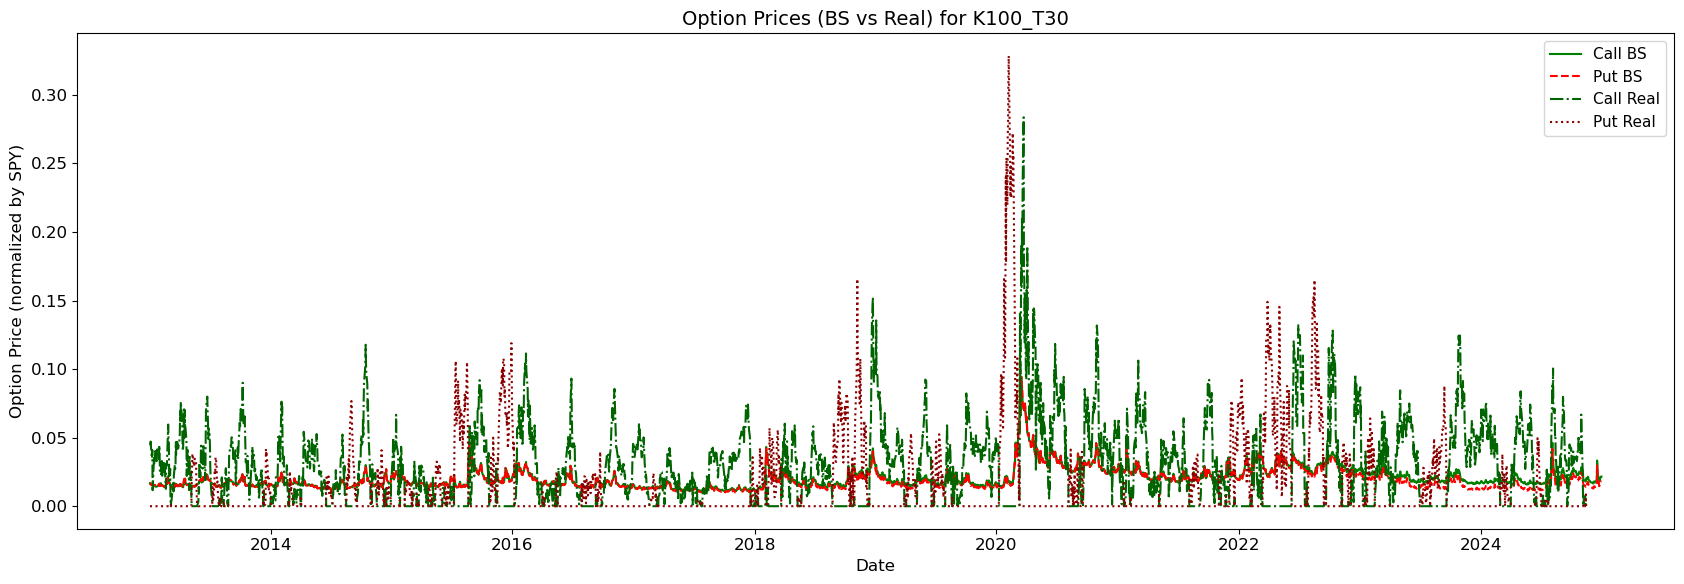

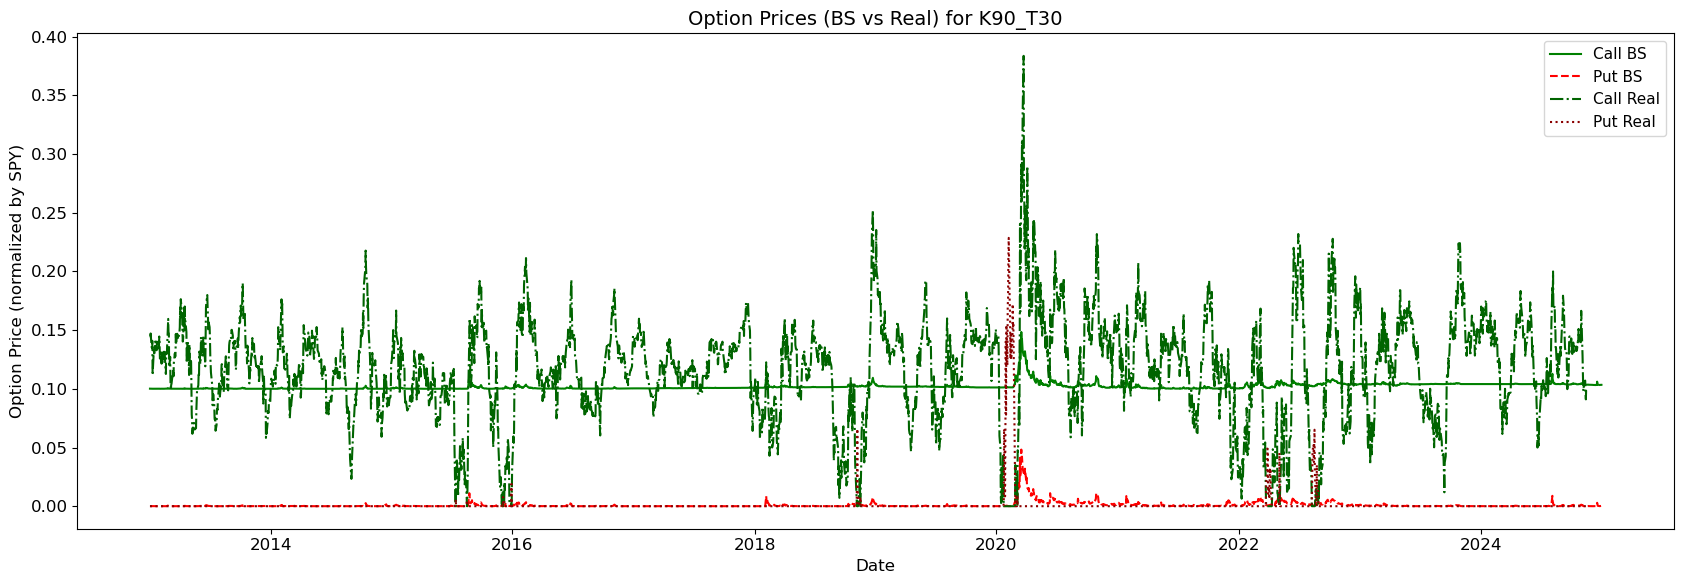

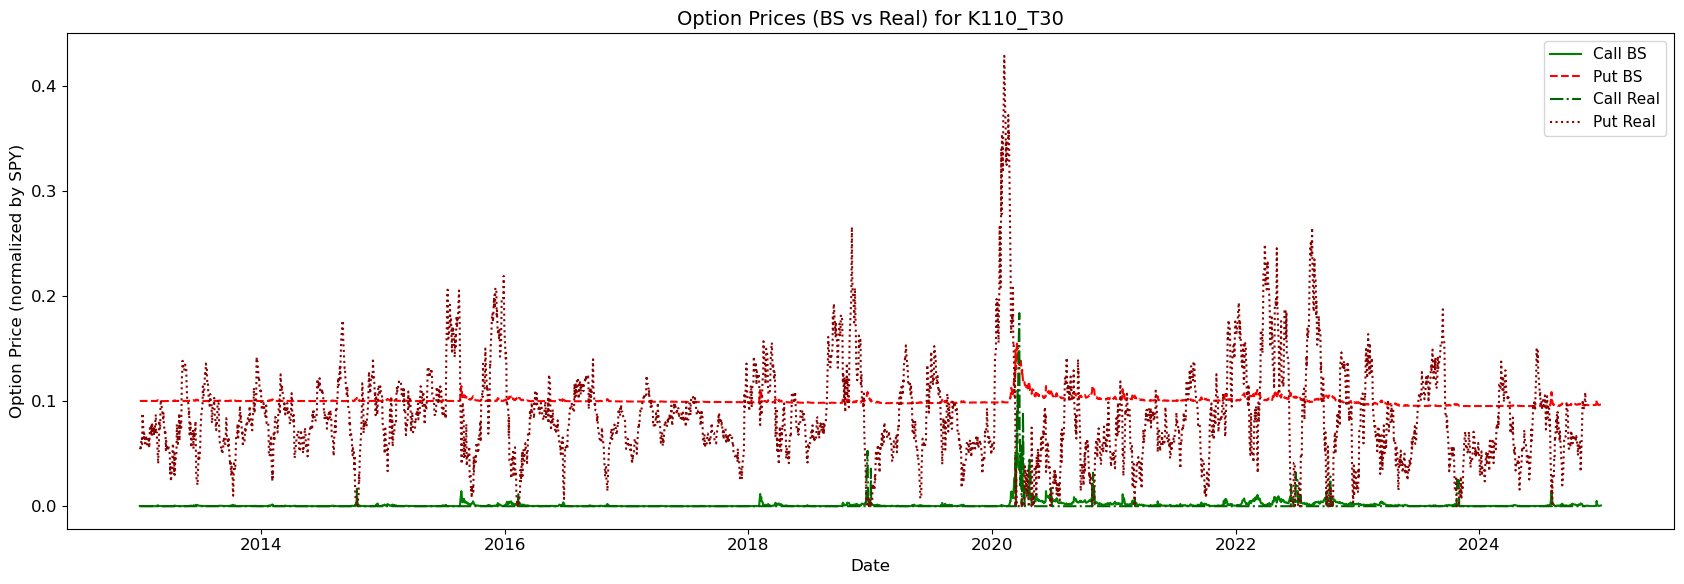

In [82]:
"""
III. Let's make some plots.
"""
selected_keys = ['K100_T30', 'K90_T30', 'K110_T30']  # ATM, ITM, OTM example

for key in selected_keys:
    df = options_chain[key]
    
    fig, ax = plt.subplots(figsize=(17, 6))
    
    ax.plot(df.index, df['call_bs'] / df['spy'], label='Call BS', linestyle='-', color='green')
    ax.plot(df.index, df['put_bs'] / df['spy'], label='Put BS', linestyle='--', color='red')
    ax.plot(df.index, df['call_real'] / df['spy'], label='Call Real', linestyle='-.', color='darkgreen')
    ax.plot(df.index, df['put_real'] / df['spy'], label='Put Real', linestyle=':', color='darkred')

    ax.set_ylabel('Option Price (normalized by SPY)')
    ax.set_xlabel('Date')
    ax.set_title(f'Option Prices (BS vs Real) for {key}')
    ax.legend()
    plt.tight_layout()
    plt.show()
